## 导入包

In [9]:
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image
from keras.layers import Input
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.models import Model
from keras import optimizers
from keras.utils import plot_model
import numpy as np
import cv2
import time

## 使用Keras构建模型

In [7]:
def vgg_model(input_shape=(224,224,3), nclass=1000):
    """
    build vgg13 model using keras with TensorFlow backend.
    :param input_shape: input shape of network, default as (224,224,3)
    :param nclass: numbers of class(output shape of network), default as 1000
    :return: vgg13 model
    """
    VGG = Sequential()
    ##重复构造，搭建神经网络 
    VGG.add(Conv2D(64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu',input_shape=input_shape))
    VGG.add(Conv2D(64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
    VGG.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'))
    
    VGG.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    VGG.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    VGG.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    
    VGG.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    VGG.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    VGG.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    
    VGG.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    VGG.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    VGG.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    
    VGG.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    VGG.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    VGG.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    
    ###把当前层节点展平 
    VGG.add(Flatten())
    VGG.add(Dense(4096, activation='relu'))
    VGG.add(Dropout(0.5))
    VGG.add(Dense(4096, activation='relu'))
    VGG.add(Dropout(0.5))
    output_ = Dense(nclass, activation='softmax')(VGG)
    
    model = Model(inputs=input_, outputs=output_)
    model.summary()
 
    opti_sgd = optimizers.sgd(lr=0.01, momentum=0.9, nesterov=True)
 
    model.compile(loss='categorical_crossentropy', optimizer=opti_sgd, metrics=['accuracy'])
 
    return model

## 风格转换

In [6]:
#model = VGG()
#plot_model(model,'VGG.png')#保存模型图
def style_transfer(pathIn='',
                   pathOut='',
                   model='',
                   width=None,
                   jpg_quality=80):
    '''
    pathIn: 原始图片的路径
    pathOut: 风格化图片的保存路径
    model: 预训练模型的路径
    width: 设置风格化图片的宽度，默认为None, 即原始图片尺寸
    jpg_quality: 0-100，设置输出图片的质量，默认80，越大图片质量越好
    '''
    
    ## 读入原始图片，调整图片至所需尺寸，然后获取图片的宽度和高度
    img = cv2.imread(pathIn)
    (h, w) = img.shape[:2]
    if width is not None:
        img = cv2.resize(img, (width, round(width*h/w)), interpolation=cv2.INTER_CUBIC)
        (h, w) = img.shape[:2]
    
    ## 从本地加载预训练模型
    #print('加载预训练模型......')
    #net = cv2.dnn.readNetFromTorch(model)
    
    ## 将图片构建成一个blob：设置图片尺寸，将各通道像素值减去平均值（比如ImageNet所有训练样本各通道统计平均值）
    ## 然后执行一次前馈网络计算，并输出计算所需的时间
    blob = cv2.dnn.blobFromImage(img, 1.0, (w, h), (103.939, 116.779, 123.680), swapRB=False, crop=False)
    model.setInput(blob)
    start = time.time()
    output = model.forward()
    end = time.time()
    print("风格迁移花费：{:.2f}秒".format(end - start))

    ## reshape输出结果, 将减去的平均值加回来，并交换各颜色通道
    output = output.reshape((3, output.shape[2], output.shape[3]))
    output[0] += 103.939
    output[1] += 116.779
    output[2] += 123.680
    output = output.transpose(1, 2, 0)
    
    ## 输出风格化后的图片
    cv2.imwrite(pathOut, output, [int(cv2.IMWRITE_JPEG_QUALITY), jpg_quality])

## 导入图片

In [14]:
for i in range(1,6):
    img = cv2.imread(./img/img0+str(i)+'.jpg')
    (h, w) = img.shape[:2]
    img = cv2.resize(img, (width, round(width*h/w)), interpolation=cv2.INTER_CUBIC)
    (h, w) = img.shape[:2]
#pathIn = './img/img02.jpg'
#pathOut = './result/result_img01_1.jpg'
#model = vgg_model(input_shape='')
#style_transfer(pathIn, pathOut, model, width=500)

In [10]:
## 读入图片，并转为浮点数组，且减去128.0，以0为中心，加快收敛速度
style = Image.open('./img/star.jpg')
style = style.resize((224,224),Image.ANTIALIAS)
style = np.array(style)
style = style.reshape(224,224,3)
style = style.astype(np.float32) - 128.0

content = Image.open('./img/img01.jpg')
content = content.resize((224,224),Image.ANTIALIAS)
content = np.array(content)
content = content.reshape(224,224,3)
content = content.astype(np.float32) - 128.0
#style = np.array(style).astype(np.float32) - 128.0
#content = cv2.imread('./img/img01.jpg')
#content = np.array(content).astype(np.float32) - 128.0

In [15]:
print(content.shape)
print(style.shape)

(224, 224, 3)
(224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


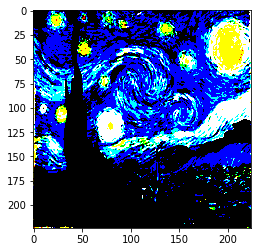

In [16]:
plt.imshow(style)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


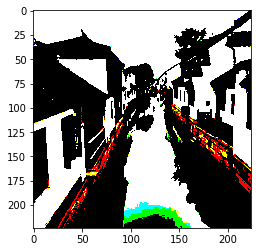

In [17]:
plt.imshow(content)

## 风格转化

In [23]:
def stylize(style_image,content_image,learning_rate=0.1,epochs=500): 
    # 结果图片 
    target = tf.Variable(tf.random_normal(content_image.shape),dtype=tf.float32) 
    style_input = tf.constant(style_image,dtype=tf.float32) 
    content_input = tf.constant(content_image, dtype=tf.float32) 
    cost = loss_function(style_input,content_input,target) 
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost) 
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess: 
        tf.initialize_all_variables().run() 
        for i in range(epochs): 
            _,loss,target_image = sess.run([train_op,cost,target]) 
            print("iter:%d,loss:%.9f" % (i, loss)) 
            if (i+1) % 100 == 0: 
                image = np.clip(target_image + 128,0,255).astype(np.uint8) 
                Image.fromarray(image).save("./neural_me_%d.jpg" % (i + 1))

In [ ]:
stylize = stylize(style,content,0.5,500)

## 加载VGG-19模型

In [ ]:
_vgg_params = None 
def vgg_params(): 
    global _vgg_params 
    if _vgg_params is None: 
        _vgg_params = sio.loadmat('/media/liuzixuan/DATA/学业/2018-2019学年/2018-2019第一学期/机器学习/项目实训/小组实训/02-用Python快速实现图片的风格迁移/imagenet-vgg-verydeep-19.mat') 
    return _vgg_params